<h1>
<center>CFRM 421/521, Spring 2023</center>
</h1>

<h1>
<center>Yevgen Revtsov</center>
</h1>

<h1>
<center>Homework 2</center>
</h1>

* **Due: Tuesday, April 29, 2024, 11:59 PM**


* Total marks: 45


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Random forest for time series data [14 marks]

In this question you will work with the NYSE dataset. Only 3 time series in this dataset will be use: `DJ_return` ($a_t$), `log_volatility` ($b_t$), and `log_volume` ($c_t$). Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/105167110/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf), which explains the meaning of the variables.

You want to predict the 1-step ahead value of `log_volume` $c_{t+1}$ using the previous values of this variable and the other two variables (`DJ_return` and `log_volatility`) up to 5 lags. So the features are $c_{t},\dots,c_{t-4},b_{t},\dots,b_{t-4},a_{t},\dots,a_{t-4}$.

If the data is stored in a file named `NYSE.csv` in your working directory, then loading the data can be done using the code below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

idx = pd.IndexSlice

data = pd.read_csv("datasets/NYSE.csv")
data['date'] = pd.to_datetime(data['date']).dt.date
data = data.set_index('date')

## (a) [3 marks]

Create the feature matrix `X` and the target variable `y`. Print at least the first 2 rows of `X` and `y` (it is acceptable that not every element of the rows are printed).

**Solution:**

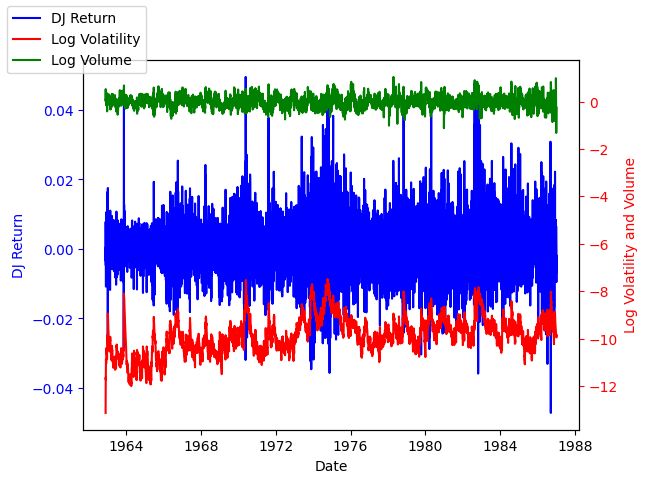

In [2]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data['DJ_return'], 'b-')
ax1.set_xlabel('Date')
ax1.set_ylabel('DJ Return', color='b')
ax2.plot(data['log_volatility'], 'r-')
ax2.plot(data['log_volume'], 'g-')
ax2.set_ylabel('Log Volatility and Volume', color='r')
ax1.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')
fig.legend(['DJ Return', 'Log Volatility', 'Log Volume'], loc='upper left')

In [3]:
# create the features frame by shifting the data by 0, 1, 2, 3, 4
# and the target is the return of the next day
data_obs = 5
X = data[['DJ_return', 'log_volatility', 'log_volume']].shift(np.array(range(data_obs)))
Y = data['log_volume'].shift(-1)
# remove the first (data_obs-1) rows and the last row
X = X.iloc[(data_obs-1): data.shape[0]-1, :]
Y = Y.iloc[(data_obs-1): data.shape[0]-1]
#
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [4]:
X.head(2)

,DJ_return_0,log_volatility_0,log_volume_0,DJ_return_1,log_volatility_1,log_volume_1,DJ_return_2,log_volatility_2,log_volume_2,DJ_return_3,log_volatility_3,log_volume_3,DJ_return_4,log_volatility_4,log_volume_4
0,0.000568,-11.728130,0.044187,-0.003462,-11.626772,0.210182,0.003845,-11.665609,0.525306,0.007813,-11.749305,0.346202,-0.004461,-13.127403,0.032573
1,-0.010824,-10.872526,0.133246,0.000568,-11.728130,0.044187,-0.003462,-11.626772,0.210182,0.003845,-11.665609,0.525306,0.007813,-11.749305,0.346202


In [5]:
Y.head(2)

0    0.133246
1   -0.011528
Name: log_volume, dtype: float64

## (b)  [5 marks]

Consider fitting a random forest to predict the 1-step ahead value of `log_volume`. The random forest must include the argument `random_state=42`, and it is useful to also include `n_jobs=-1` (you can use `n_job=-1` throughout this homework wherever it is avaliable). Use 3-fold time series CV split, with the test set split 50% into a validation set and 50% into the actual test set, to tune the hyperparameters `n_estimators` taking the values  200, 400, 600, and the cost-complexity pruning parameter $\alpha$ taking the values $10^{-k}$, $k=1,3,5,7$. When tuning hyperparameters on the validation sets, fit the model only on a random 10% sample of the instances of the training set on the same CV fold to reduce computational time (that is, use the same reduced training set for all the hyperparameters, but a different one for each CV fold). Note this will still preserve the correct time ordering, and the reduce training set should not be used when fitting and evaluating the best model on the test set. The performance measure is RMSE. Report the best hyperparameters.

**Solution:**

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd

def random_block(arr, size, seed):
    np.random.seed(seed)
    n = int(len(arr) * size)
    start = np.random.randint(0, len(arr) - n)
    return start,start+n

n_estimators = [200, 400, 600]
alphas = [10**(-1*k)for k in [1, 3, 5, 7]]
# alphas = [10**(-1*k)for k in [7, 9, 11, 13]]
ts_cv = TimeSeriesSplit(n_splits=3)

rf_rmse = pd.DataFrame(
    index=pd.MultiIndex.from_product([n_estimators, alphas], names=["n_estimators", "alphas"]))
i = 0
best_rmse = np.inf
best_model = None
for train_index, test_index in ts_cv.split(X):
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))
        print(f'Train: {train_index[0]} - {train_index[-1]}')
        print(f'Valid: {valid_index[0]} - {valid_index[-1]}')
        print(f'Test: {test_index[0]} - {test_index[-1]}')

        # Split
        X_train, X_valid, X_test = X.loc[train_index,: ], X.loc[valid_index, :], X.loc[test_index, :]
        y_train, y_valid, y_test = Y.loc[train_index], Y.loc[valid_index], Y.loc[test_index]

        # sample a 10% period of the training data
        start, end = random_block(X_train.index, size=0.1, seed=42)
        X_sample = X_train.iloc[start:end, :]
        y_sample = y_train.iloc[start:end]

        for n in n_estimators:
            for alpha in alphas:
                rfr = RandomForestRegressor(
                    random_state=42,
                    n_jobs=-1,
                    n_estimators=n,
                    ccp_alpha=alpha,
                )
                rfr.fit(X_sample, y_sample)
                y_val_rf = rfr.predict(X_valid)
                rmse = np.sqrt(mean_squared_error(y_valid, y_val_rf))
                rf_rmse.loc[idx[n, alpha], i] = rmse
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = rfr
        i += 1


Train: 0 - 1512
Valid: 1513 - 2267
Test: 2268 - 3022
Train: 0 - 3023
Valid: 3024 - 3778
Test: 3779 - 4533
Train: 0 - 4534
Valid: 4535 - 5289
Test: 5290 - 6044


In [7]:
rf_rmse.mean(axis=1).sort_values()

n_estimators  alphas      
600           1.000000e-03    0.173280
              1.000000e-05    0.173329
              1.000000e-07    0.173335
400           1.000000e-07    0.173416
              1.000000e-05    0.173424
200           1.000000e-03    0.173471
              1.000000e-07    0.173492
              1.000000e-05    0.173502
400           1.000000e-03    0.173588
200           1.000000e-01    0.236754
400           1.000000e-01    0.236846
600           1.000000e-01    0.236854
dtype: float64

## (c)  [2 marks]

Using the same time series split as in (b), compute the RMSE of the best fitting model on the test set, and include a plot of the true values and predicted values on the test set of the last fold (the fold closest to the current time) of the CV.

**Solution**:


Train: 0 - 4534
Valid: 4535 - 5289
Test: 5290 - 6044
RMSE: 0.22621164688002868


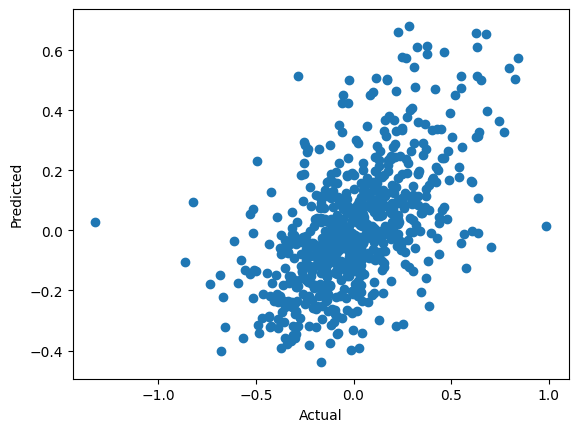

In [8]:
i = 0
for train_index, test_index in ts_cv.split(X):
    if i == 2:
        print()
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))
        print(f'Train: {train_index[0]} - {train_index[-1]}')
        print(f'Valid: {valid_index[0]} - {valid_index[-1]}')
        print(f'Test: {test_index[0]} - {test_index[-1]}')

        # Split
        X_train, X_valid, X_test = X.loc[train_index,: ], X.loc[valid_index, :], X.loc[test_index, :]
        y_train, y_valid, y_test = Y.loc[train_index], Y.loc[valid_index], Y.loc[test_index]

        # rfr = RandomForestRegressor(
        #     random_state=42,
        #     n_jobs=-1,
        #     n_estimators=600,
        #     ccp_alpha=1e-3,
        # )
        # rfr.fit(X_train, y_train)
        y_test_rf = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_test_rf))
        print(f"RMSE: {rmse}")

        plt.scatter(y_test, y_test_rf)
        # plt.xlim(-0.05, 0.05)
        # plt.ylim(-0.05, 0.05)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.show()
        break
    i += 1



## (d) [2 marks]

It is often useful to check that your model is not worse than a very simple method of prediction. On the test set, compute the RMSE of a model that simply predicts the 1-step ahead value of `log_volume` $c_{t+1}$ as the current value $c_t$, and compare this to the best fitting random forest model.

**Solution**:

In [9]:
np.sqrt(mean_squared_error(Y.iloc[1:], Y.shift(1).iloc[1:]))

np.float64(0.18886372498700638)

The out-of-sample RMSE for the best model is 0.2262 while the simple prediction using the current value has RMSE OF 0.1888

## (e) [2 marks]

Compute the feature importances of the best fitting model. Which feature is the most important and what is its feature importance value?

**Solution:**

In [10]:
# pull out the final model, look at the importance of features
sorted(zip(
    rfr.feature_importances_,
    X_train.columns),
    reverse=True
)

[(np.float64(0.6504204823903624), 'log_volume_0'),
 (np.float64(0.049946673796195544), 'DJ_return_0'),
 (np.float64(0.04130303742393461), 'log_volume_3'),
 (np.float64(0.040444019342251246), 'log_volume_4'),
 (np.float64(0.029795885814560052), 'log_volume_2'),
 (np.float64(0.0254727906105144), 'log_volume_1'),
 (np.float64(0.023299438258321245), 'DJ_return_4'),
 (np.float64(0.022786450408473935), 'DJ_return_3'),
 (np.float64(0.022361493524212298), 'DJ_return_1'),
 (np.float64(0.019944562106772167), 'log_volatility_0'),
 (np.float64(0.019536833274652814), 'log_volatility_2'),
 (np.float64(0.017382832855270976), 'DJ_return_2'),
 (np.float64(0.01260857730350357), 'log_volatility_1'),
 (np.float64(0.01252286219096874), 'log_volatility_3'),
 (np.float64(0.012174060700005958), 'log_volatility_4')]

The most important feature is the most recent log volume, with the importance value 0.9994

# 2. SVM classification and regression [11 marks]

For all SVM models in this question use a standard scaler.

## (a) [2 marks]

In this question, a SVM is used for classification for the MNIST dataset. The following code loads the MNIST dataset, creates the test set, and to reduce training time, takes a random sample of 2000 points from the full training set to use as your actual training set stored in `X` and `y`. Do not shuffle the data.

Hint: Reading the solution to Question 9 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb) (2nd edition) on the textbook website may help with this question.

In [11]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, cache=True, parser='auto')
X_train = mnist["data"][:60000]
X_test  = mnist["data"][60000:]
y_train = mnist["target"][:60000]
y_test  = mnist["target"][60000:]

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

N = 2000
split_obj = StratifiedShuffleSplit(n_splits=1,
                               test_size=N/60000, random_state=42)
for other_idx, subsample_idx in split_obj.split(X_train, y_train):
    X = X_train[subsample_idx]
    y = y_train[subsample_idx]

**Task:** Consider fitting the linear SVM classifier (`LinearSVC`) with `max_iter=50000`. For this model, optimize the hyperparameter $C$ using 3-fold CV over the values $10^{-k}$, $k=0,1,\dots,9$, where the performance measure is accuracy. What is the best $C$ and what is the accuracy in this case?

**Solution:**

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn.metrics as metrics
from scipy.stats import randint, loguniform


In [14]:
"""
- 3-fold CV
- iterate hyperparameters
"""
preproc = ColumnTransformer([], remainder=StandardScaler())

svc_pipeline = Pipeline([
    ('preproc', preproc),
    ('svc', LinearSVC(max_iter=50000))
])

params = [{
    'svc__C': [10**(-1*k)for k in range(0, 10)],
}]

grid_search = GridSearchCV(
    svc_pipeline,
    params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
)


In [15]:
grid_search.fit(X, y)

/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/util

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[])),
                                       ('svc', LinearSVC(max_iter=50000))]),
             n_jobs=-1,
             param_grid=[{'svc__C': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                     1e-07, 1e-08, 1e-09]}],
             scoring='accuracy')

In [16]:
print(grid_search.best_params_)

{'svc__C': 0.01}


In [17]:
grid_search.best_score_

np.float64(0.8329911620766194)

In [18]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values('mean_test_score', ascending=False).T

,2,3,4,1,0,5,6,7,8,9
mean_fit_time,2.122206,1.171005,0.644235,11.911111,84.333067,0.313516,0.227679,0.182131,0.145241,0.115952
std_fit_time,0.072188,0.060385,0.006726,0.565756,2.171668,0.017943,0.010619,0.003467,0.008985,0.009302
mean_score_time,0.00541,0.005984,0.00812,0.00421,0.003779,0.004612,0.004452,0.004464,0.004496,0.005071
std_score_time,0.001089,0.000659,0.003947,0.000188,0.000825,0.000203,0.000029,0.0003,0.000348,0.00072
param_svc__C,0.01,0.001,0.0001,0.1,1.0,0.00001,0.000001,0.0,0.0,0.0
params,{'svc__C': 0.01},{'svc__C': 0.001},{'svc__C': 0.0001},{'svc__C': 0.1},{'svc__C': 1},{'svc__C': 1e-05},{'svc__C': 1e-06},{'svc__C': 1e-07},{'svc__C': 1e-08},{'svc__C': 1e-09}
split0_test_score,0.845577,0.836582,0.829085,0.832084,0.802099,0.784108,0.749625,0.745127,0.743628,0.743628
split1_test_score,0.838081,0.823088,0.82009,0.817091,0.805097,0.773613,0.737631,0.722639,0.722639,0.722639
split2_test_score,0.815315,0.809309,0.803303,0.798799,0.791291,0.752252,0.719219,0.713213,0.711712,0.711712
mean_test_score,0.832991,0.822993,0.817493,0.815991,0.799496,0.769991,0.735492,0.726993,0.725993,0.725993


## (b) [2 marks]

**Task:** Now consider fitting a SVM with a Gaussian RBF kernel and `max_iter=50000`. For this model, optimize the hyperparameters $C$ over the distrbution `uniform(1,10)` and $\gamma$ over the distribution `loguniform(0.0001, 0.1)` from `scipy.stats.loguniform` with 10 random samples. The `loguniform(a,b)` function takes a random sample from the probability distribution with pdf $f(x)\propto 1/x, x\in[a,b]$. Again, use 3-fold CV and the performance measure is accuracy. What are the best hyperparameters and what is the accuracy in this case?

**Solution:**

In [19]:
preproc = ColumnTransformer([], remainder=StandardScaler())

rbf_pipeline = Pipeline([
    ('preproc', preproc),
    ('rbf', SVC(kernel="rbf", max_iter=50000))
])

rand_params = [{
    'rbf__C': randint(low=1, high=10),
    'rbf__gamma': loguniform(a=0.0001, b=0.1),
}]

rand_grid_search = RandomizedSearchCV(
    rbf_pipeline,
    rand_params,
    cv=3,
    n_iter=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
)


In [20]:
rand_grid_search.fit(X, y)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[])),
                                             ('rbf', SVC(max_iter=50000))]),
                   n_jobs=-1,
                   param_distributions=[{'rbf__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x10f7fc6e0>,
                                         'rbf__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x10f7fc590>}],
                   random_state=42, scoring='accuracy')

In [21]:
print(rand_grid_search.best_params_)

{'rbf__C': 8, 'rbf__gamma': np.float64(0.0010025956902289571)}


In [22]:
rand_grid_search.best_score_

np.float64(0.8889969429699565)

In [23]:
cv_res = pd.DataFrame(rand_grid_search.cv_results_)
cv_res.sort_values('mean_test_score', ascending=False).T

,4,3,6,8,2,1,9,5,0,7
mean_fit_time,0.237961,0.234943,0.196879,0.191695,0.441749,0.566866,0.454304,0.545983,0.589973,0.500652
std_fit_time,0.019802,0.016836,0.009531,0.003548,0.016485,0.058113,0.022037,0.013729,0.017812,0.023009
mean_score_time,0.168918,0.163013,0.173672,0.145172,0.203178,0.230475,0.178176,0.203111,0.249127,0.190173
std_score_time,0.006961,0.005824,0.004729,0.001672,0.013281,0.023788,0.000567,0.017324,0.006896,0.002721
param_rbf__C,8,7,6,6,7,8,5,8,7,8
param_rbf__gamma,0.001003,0.000149,0.000148,0.000101,0.002175,0.006251,0.007119,0.013311,0.024526,0.031429
params,"{'rbf__C': 8, 'rbf__gamma': 0.0010025956902289...","{'rbf__C': 7, 'rbf__gamma': 0.0001493656855461...","{'rbf__C': 6, 'rbf__gamma': 0.0001476504371359...","{'rbf__C': 6, 'rbf__gamma': 0.0001005394019469...","{'rbf__C': 7, 'rbf__gamma': 0.002175195311877766}","{'rbf__C': 8, 'rbf__gamma': 0.006251373574521752}","{'rbf__C': 5, 'rbf__gamma': 0.007119418600172993}","{'rbf__C': 8, 'rbf__gamma': 0.013311216080736894}","{'rbf__C': 7, 'rbf__gamma': 0.024526126311336778}","{'rbf__C': 8, 'rbf__gamma': 0.03142880890840111}"
split0_test_score,0.895052,0.884558,0.878561,0.872564,0.875562,0.781109,0.749625,0.593703,0.382309,0.236882
split1_test_score,0.889055,0.901049,0.89955,0.892054,0.866567,0.778111,0.746627,0.605697,0.346327,0.248876
split2_test_score,0.882883,0.869369,0.864865,0.861862,0.866366,0.758258,0.74024,0.600601,0.334835,0.24024


## (c) [2 mark]

**Task:** Choose the best model in (a) and (b). Then for this model, evaluate the accuracy on the test set, which is stored in `X_test` and `y_test`.

**Solution:**

In [24]:
final_model = grid_search.best_estimator_
final_pred = final_model.predict(X_test)
print(metrics.accuracy_score(y_true=y_test, y_pred=final_pred))

0.8532


/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [25]:
final_model = rand_grid_search.best_estimator_
final_pred = final_model.predict(X_test)
print(metrics.accuracy_score(y_true=y_test, y_pred=final_pred))

0.9129


## (d) [3 marks]

Consider the original source of the California housing data (which is different from the modified dataset used in Homework 1) in Scikit-Learn. The data is obtained and split using the code below. The training set is stored in `X_train` and `y_train`. Do not shuffle the data.

Hint: Reading the solution to Question 11 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb) (3rd edition) on the textbook website may help with this question.

In [26]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X = housing.data
y = housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Task:** Consider SVM regression with a Gaussian RBF kernel and a sigmoid kernel with `max_iter=50000`. For both models, use randomized search to choose good hyperparameter values for `C` and `gamma`, and set the arguement `random_state=42`. For both models, optimize the hyperparameters $C$ over the distrbution `uniform(1,20)` and $\gamma$ over the distribution `loguniform(0.0001, 0.1)` with 20 random samples. To save training time, use only the first 2000 instances of `X_train` and `y_train` (which have been randomly shuffled already) for the search. Again, use 3-fold CV and the performance measure is MSE. What are the best hyperparameters and what is the MSE in this case?

**Solution:**

In [27]:
preproc = ColumnTransformer([], remainder=StandardScaler())

svr_pipeline = Pipeline([
    ('preproc', preproc),
    ('svr', SVR(max_iter=50000))
])

rand_params = [{
    'svr__kernel': ['rbf', 'sigmoid'],
    'svr__C': randint(low=1, high=20),
    'svr__gamma': loguniform(a=0.0001, b=0.1),
}]

svr_search = RandomizedSearchCV(
    svr_pipeline,
    rand_params,
    cv=3,
    n_iter=40,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

In [28]:
svr_search.fit(X_train[:2000], y_train[:2000])


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[])),
                                             ('svr', SVR(max_iter=50000))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions=[{'svr__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12f258a50>,
                                         'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12eb96d50>,
                                         'svr__kernel': ['rbf', 'sigmoid']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [29]:
print(svr_search.best_params_)

{'svr__C': 8, 'svr__gamma': np.float64(0.03416658290996044), 'svr__kernel': 'rbf'}


In [30]:
svr_search.best_score_

np.float64(-0.5743034984289631)

In [31]:
cv_res = pd.DataFrame(svr_search.cv_results_)
cv_res.sort_values('mean_test_score', ascending=False).T

,24,14,1,0,12,30,37,31,15,20,...,6,5,16,25,11,35,28,33,21,22
mean_fit_time,0.042547,0.043866,0.031091,0.029193,0.028307,0.037094,0.037475,0.033146,0.031831,0.036212,...,0.024786,0.031446,0.030073,0.042023,0.035414,0.031741,0.03473,0.037774,0.036602,0.043483
std_fit_time,0.006164,0.007229,0.00036,0.000632,0.002522,0.002939,0.001735,0.006599,0.007353,0.008688,...,0.002845,0.009495,0.000987,0.006778,0.005093,0.003384,0.005745,0.002961,0.003299,0.003934
mean_score_time,0.018298,0.022435,0.017451,0.016132,0.01697,0.017092,0.016616,0.024418,0.016359,0.019141,...,0.006536,0.006666,0.009042,0.006535,0.006554,0.010371,0.00685,0.009372,0.012134,0.014358
std_score_time,0.003983,0.000658,0.002185,0.000043,0.001838,0.00129,0.00045,0.003688,0.000072,0.003239,...,0.000241,0.000378,0.004201,0.000479,0.0004,0.002332,0.000093,0.000444,0.003055,0.002711
param_svr__C,8,14,11,7,3,19,15,3,2,10,...,6,2,7,18,15,5,9,7,18,10
param_svr__gamma,0.034167,0.026619,0.021831,0.024526,0.038003,0.0132,0.013795,0.020597,0.01129,0.005048,...,0.000101,0.014655,0.006761,0.00416,0.007164,0.015446,0.020736,0.035491,0.021154,0.04836
param_svr__kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid
params,"{'svr__C': 8, 'svr__gamma': 0.0341665829099604...","{'svr__C': 14, 'svr__gamma': 0.026619018884890...","{'svr__C': 11, 'svr__gamma': 0.021830968390524...","{'svr__C': 7, 'svr__gamma': 0.0245261263113367...","{'svr__C': 3, 'svr__gamma': 0.0380032921404520...","{'svr__C': 19, 'svr__gamma': 0.013199942261535...","{'svr__C': 15, 'svr__gamma': 0.013795402040204...","{'svr__C': 3, 'svr__gamma': 0.0205973353574372...","{'svr__C': 2, 'svr__gamma': 0.0112901335590926...","{'svr__C': 10, 'svr__gamma': 0.005047786565710...",...,"{'svr__C': 6, 'svr__gamma': 0.0001005394019469...","{'svr__C': 2, 'svr__gamma': 0.0146553541187277...","{'svr__C': 7, 'svr__gamma': 0.0067606736669594...","{'svr__C': 18, 'svr__gamma': 0.004159837801719...","{'svr__C': 15, 'svr__gamma': 0.007164040428191...","{'svr__C': 5, 'svr__gamma': 0.0154460890750470...","{'svr__C': 9, 'svr__gamma': 0.0207364451779050...","{'svr__C': 7, 'svr__gamma': 0.0354907954609597...","{'svr__C': 18, 'svr__gamma': 0.021154290797261...","{'svr__C': 10, 'svr__gamma': 0.048359527764659..."
split0_test_score,-0.571952,-0.573172,-0.575287,-0.575424,-0.576883,-0.582357,-0.584026,-0.59159,-0.617322,-0.624021,...,-0.893537,-3.361665,-4.107111,-4.583021,-10.042324,-9.77704,-27.75157,-40.193004,-58.860484,-75.643654
split1_test_score,-0.584406,-0.586247,-0.591852,-0.592845,-0.590447,-0.603525,-0.603369,-0.609844,-0.645469,-0.650025,...,-0.947208,-1.08646,-0.907545,-0.828142,-1.788793,-2.777783,-8.849262,-15.899048,-18.706899,-34.715576


## (e) [2 marks]

**Task:** Choose the best model in (d). But now refit it on the full training set (not just the first 2000 instances). Then for this model, evaluate the RMSE on the test set, which is stored in `X_test` and `y_test`.

In [32]:
final_model = svr_search.best_estimator_
final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test)
print(metrics.root_mean_squared_error(y_true=y_test, y_pred=final_pred))

0.625970529192339


**Solution:**

# 3. Voting classifiers [11 marks]
## (a)  [4 marks]

Consider the MNIST dataset. To save computational time, after spliting into a training, validation and test set, we keep only the first 5000 instances of the training set, and only the first 1000 instances of the validation and test set, as given by the following code.

In [33]:
N = 50_000
M = 60_000
X_train = mnist["data"][:N][:5000]
y_train = mnist["target"][:N][:5000]
X_valid  = mnist["data"][N:M][:1000]
y_valid = mnist["target"][N:M][:1000]
X_test  = mnist["data"][M:][:1000]
y_test = mnist["target"][M:][:1000]

Do not shuffle the data and do not use a standard scaler. Train the following classifiers on the training set:

(i) a multilayer perceptron classifier using the class `MLPClassifier()` from `sklearn.neural_network` with arguments `random_state=42`,

(ii) an extra-trees classifier with arguments `n_estimators=100, n_jobs=-1, random_state=42`,

(iii) an AdaBoost classifier  with arguments  `n_estimators=50, learning_rate=0.2, random_state=42`,

(iv) a gradient boosting classifier using the class `GradientBoostingClassifier()` with arguments `max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42`.

Report the accuracy of each trained classifier on the validation set.

Hint: Reading the solution to Question 8 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

**Solution:**

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder


In [35]:
mlp_cls = MLPClassifier(random_state=42)
mlp_cls.fit(X_train, y_train)

y_pred_mlp = mlp_cls.predict(X_valid)

/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [36]:
et_cls = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)
et_cls.fit(X_train, y_train)

y_pred_et = et_cls.predict(X_valid)

In [37]:
ada_cls = AdaBoostClassifier(n_estimators=50, learning_rate=0.2, random_state=42)
ada_cls.fit(X_train, y_train)

y_pred_ada = ada_cls.predict(X_valid)


In [38]:
gb_cls = GradientBoostingClassifier(n_estimators=10, max_depth=2, learning_rate=0.25, random_state=42)
gb_cls.fit(X_train, y_train)

y_pred_gb = gb_cls.predict(X_valid)

In [39]:
print(f'MLP accuracy: {metrics.accuracy_score(y_valid, y_pred_mlp)}')
print(f'ExtraTrees accuracy: {metrics.accuracy_score(y_valid, y_pred_et)}')
print(f'AdaBoost accuracy: {metrics.accuracy_score(y_valid, y_pred_ada)}')
print(f'GradientBoosting accuracy: {metrics.accuracy_score(y_valid, y_pred_gb)}')



MLP accuracy: 0.879
ExtraTrees accuracy: 0.948
AdaBoost accuracy: 0.431
GradientBoosting accuracy: 0.802


## (b)  [5 marks]

Train the following models:

* a hard-voting ensemble classifier for all the models in (a)
* a soft-voting ensemble classifier for all the models in (a)
* a hard-voting ensemble classifier dropping the worst performing model in (a)
* a soft-voting ensemble classifier dropping the worst performing model in (a)

Evaluate the accuracy of these voting classifiers on the validation set, and compare it to the performance of the individual models in (a).

**Solution:**

In [40]:
voting_hard = VotingClassifier(estimators=[('mlp', mlp_cls), ('et', et_cls), ('ada', ada_cls), ('gb', gb_cls)], voting='hard')
voting_hard.fit(X_train, y_train)
y_pred_voting_hard = voting_hard.predict(X_valid)

/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [41]:
voting_soft = VotingClassifier(estimators=[('mlp', mlp_cls), ('et', et_cls), ('ada', ada_cls), ('gb', gb_cls)], voting='soft')
voting_soft.fit(X_train, y_train)
y_pred_voting_soft = voting_soft.predict(X_valid)

/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [42]:
# dropping AdaBoost as the poorest performer
voting_hard_drop = VotingClassifier(estimators=[('mlp', mlp_cls), ('et', et_cls), ('gb', gb_cls)], voting='hard')
voting_hard_drop.fit(X_train, y_train)
y_pred_voting_hard_drop = voting_hard_drop.predict(X_valid)

/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [43]:
# repeat for soft voting
voting_soft_drop = VotingClassifier(estimators=[('mlp', mlp_cls), ('et', et_cls), ('gb', gb_cls)], voting='soft')
voting_soft_drop.fit(X_train, y_train)
y_pred_voting_soft_drop = voting_soft_drop.predict(X_valid) 

/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [44]:
print(f'Voting hard accuracy: {metrics.accuracy_score(y_valid, y_pred_voting_hard)}')
print(f'Voting soft accuracy: {metrics.accuracy_score(y_valid, y_pred_voting_soft)}')
print(f'Voting hard accuracy (dropping AdaBoost): {metrics.accuracy_score(y_valid, y_pred_voting_hard_drop)}')
print(f'Voting soft accuracy (dropping AdaBoost): {metrics.accuracy_score(y_valid, y_pred_voting_soft_drop)}')

Voting hard accuracy: 0.897
Voting soft accuracy: 0.885
Voting hard accuracy (dropping AdaBoost): 0.911
Voting soft accuracy (dropping AdaBoost): 0.885


ExtraTrees standalone algorithm is the best performer, beating out even the voting algorithms. This is surprising as I would expect the voting algorhtims to at least be as good at the standalone algos. From the voting models, the hard voting model dropping the lowest performer (AdaBoost) has the highest accuracy, followed by hard voting with all models.

## (c)  [2 marks]

Of the four voting classifiers in (b), choose the best model. Then evaluate the accuracy of this model on the test set.

**Solution:**
Choosing the Voting hard model with AdaBoost dropped.

In [45]:
y_pred_voting_hard_drop_test = voting_hard_drop.predict(X_test)
print(f'Voting hard accuracy (dropping AdaBoost) on test set: {metrics.classification_report(y_test, y_pred_voting_hard_drop_test)}')

Voting hard accuracy (dropping AdaBoost) on test set:               precision    recall  f1-score   support

           0       0.92      0.98      0.95        85
           1       0.95      0.98      0.96       126
           2       0.87      0.91      0.89       116
           3       0.89      0.88      0.88       107
           4       0.89      0.90      0.90       110
           5       0.89      0.85      0.87        87
           6       0.95      0.95      0.95        87
           7       0.92      0.86      0.89        99
           8       0.89      0.84      0.87        89
           9       0.89      0.89      0.89        94

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


# 4. Stacking [9 marks]

We continue with the setting of Question 3. The training set, validation set and test set are the same. In Question 3, we have used predetermined rules (that is, hard-voting and soft-voting) to build the ensemble prediction. **Stacking** is an ensemble method in which you train a model (called a **blender**) to aggregate the result of each predictor into an ensemble prediction.

Hint: Reading the subsection "Stacking" in Chapter 7 of the textbook and the solution to Question 9 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

## (a)  [3 marks]

For each of the four classifiers in Question 3(a), make 5000 clean predictions on the training set with 3-fold cross validation using `sklearn.model_selection.cross_val_predict()`. You should end up with four predictions per observation. Print at least the first 5 rows of `pred`. Next, apply one-hot encoding to `pred` since these predictions are class labels.

**Solution:**

In [46]:
from sklearn.model_selection import cross_val_predict

In [47]:
mlp_cross = cross_val_predict(mlp_cls, X_train, y_train, cv=3)
et_cross = cross_val_predict(et_cls, X_train, y_train, cv=3)
ada_cross = cross_val_predict(ada_cls, X_train, y_train, cv=3)
gb_cross = cross_val_predict(gb_cls, X_train, y_train, cv=3)

/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/util

In [48]:
pred = pd.DataFrame(np.column_stack([mlp_cross, et_cross, ada_cross, gb_cross]), columns=['mlp', 'et', 'ada', 'gb'])
pred.head(5)

,mlp,et,ada,gb
0,5,5,0,3
1,0,0,0,0
2,4,4,7,4
3,1,1,1,1
4,9,9,4,9


In [49]:
def one_hot_encode(pred):
    cat_encoder = OneHotEncoder()
    cat_encoder.fit(pred)
    pred_encoded = pd.DataFrame(
        data=cat_encoder.transform(pred).toarray(),
        columns=cat_encoder.get_feature_names_out(),
        index=pred.index)
    return pred_encoded

pred_encoded = one_hot_encode(pred)
pred_encoded.head(5)

,mlp_0,mlp_1,mlp_2,mlp_3,mlp_4,mlp_5,mlp_6,mlp_7,mlp_8,mlp_9,...,gb_0,gb_1,gb_2,gb_3,gb_4,gb_5,gb_6,gb_7,gb_8,gb_9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## (b) [3 marks]
Use the predictions in (a) as features and the actual label of the observations as the target. Train a random forest classifier on the training set with the parameters `n_estimators=100, random_state=42`.  This classifier is a blender. 

**Solution:**

In [50]:
blender = RandomForestClassifier(n_estimators=100, random_state=42).fit(pred_encoded, y_train)

## (c) [3 marks]

Obtain the predictions of the blender on the test set by feeding predictions on the test set from the four classifiers in Question 3(a) into the blender trained in Question 4(b). Do not retrain the blender. These are called stacking predictions. Report the accuracy of your stacking predictions on the test set and compare this to the results in Question 3(c).

**Solution:**

In [51]:
mlp_test_pred = mlp_cls.predict(X_test)
et_test_pred = et_cls.predict(X_test)
ada_test_pred = ada_cls.predict(X_test)
gb_test_pred = gb_cls.predict(X_test)

test_pred = pd.DataFrame(np.column_stack([mlp_test_pred, et_test_pred, ada_test_pred, gb_test_pred]), columns=['mlp', 'et', 'ada', 'gb'])
test_pred_encoded = one_hot_encode(test_pred)

test_pred_encoded.head(5)

y_blender = blender.predict(test_pred_encoded)

print(metrics.classification_report(y_test, y_blender))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        85
           1       0.99      0.97      0.98       126
           2       0.95      0.92      0.93       116
           3       0.90      0.88      0.89       107
           4       0.94      0.92      0.93       110
           5       0.90      0.90      0.90        87
           6       0.94      0.97      0.95        87
           7       0.92      0.94      0.93        99
           8       0.88      0.88      0.88        89
           9       0.88      0.91      0.90        94

    accuracy                           0.93      1000
   macro avg       0.92      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erevtsov/dev/cfrm/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Stacking resulted in better performance than voting.